In [2]:
import os
import pandas as pd
import numpy as np
from collections import Counter
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def get_point_value(g):
    for path in g.collections:
        points = path.get_offsets()
        print(f"hue: {path.get_label()}")
        v = np.array(points[:, 1])
        print(np.around(v,4))
        print(np.around([np.min(v), np.median(v), np.max(v)], 4))


In [4]:
# # version 1
# polygon_path = "/proj/quic-PG0/data/result-logs/client/2022-05-17_11:17:22"
# anycast_path = "/proj/quic-PG0/data/result-logs/client/2022-05-18_21:52:20"

# version 2
polygon_path = "/proj/quic-PG0/data/result-logs/client/2022-05-30_21:55:40"
anycast_path = "/proj/quic-PG0/data/result-logs/client/2022-05-30_19:58:32"


In [5]:
data_cpu = []
data_all = []
data_all_ok_type = []
error_time_list = []

path_dict = {polygon_path:'polygon',
            anycast_path: 'anycast'}


for root_path in [anycast_path, polygon_path]:
    all_n = 0
    error_n = 0
    for dir_name in os.listdir(root_path):
        for file_name in os.listdir(os.path.join(root_path, dir_name)):
            if '_tmp.txt' not in file_name:
                continue
            file_path = os.path.join(root_path, dir_name, file_name)
            port = int(file_name.split('_')[1])

            with open(file_path, 'r') as f:
                type_lines = f.readlines()
                try:
                    request_type = type_lines[4].strip().split(' ')[-1]
                    data_all.append([path_dict[root_path], dir_name, request_type, 
                                          int(file_name.split('_')[-2]) // 1000])
                    file_path_2 = file_path.replace('_tmp', '_2')
                    with open(file_path_2, 'r') as f_plt:
                        plt_lines = f_plt.readlines()
                        if plt_lines[-1] == '\n':
                            tmp.append(plt_lines)
                        plt_time = int(plt_lines[-1].replace('PLT: ','').replace(' microseconds\n','')) / 1000000
                        data_all_ok_type.append([path_dict[root_path], 
                                                 dir_name, request_type, port,
                                              int(file_name.split('_')[-2]) // 1000, int(int(file_name.split('_')[-2]) / 1000 + plt_time) ]) 
                except Exception as e:
                    error_n += 1
                    error_time_list.append([path_dict[root_path], dir_name, 
                                            request_type,
                                            int(file_name.split('_')[-2]) // 1000 ])
                    continue
                    
                if request_type == 'cpu':
                    all_n += 1
                    file_path_3 = file_path.replace('_tmp', '_3')
                    
                    if not os.path.exists(file_path_3):
                        error_time_list.append([path_dict[root_path], dir_name, int(file_name.split('_')[-2]) // 1000 ])
                        error_n += 1
                        continue
                    with open(file_path_3, 'r') as f_cpu:
                        lines = f_cpu.readlines()
                        excution_time = 0
                        for line in lines:
                            if 'st' in line:
                                st_timestamp = float(line.strip().split(' ')[1])
                            elif 'en' in line:
                                en_timestamp = float(line.strip().split(' ')[1])     
                                excution_time += (en_timestamp - st_timestamp)
                                data_cpu.append([path_dict[root_path], dir_name, 
                                             st_timestamp, en_timestamp,
                                                en_timestamp - st_timestamp]) 
                            else:
                                continue
#                         data_cpu.append([path_dict[root_path], dir_name, 
#                                      st_timestamp, en_timestamp,
#                                         excution_time])   
                else:
                    continue
                    
    print(path_dict[root_path], all_n, error_n)
data_cpu = pd.DataFrame(data_cpu, columns=['tag', 'client',
                                   'st_timestamp', 'en_timestamp', 'value'])
error_time_list = pd.DataFrame(error_time_list, columns=['tag', 'client',
                                                         'request_type',
                                                       'st_timestamp'])
data_all = pd.DataFrame(data_all, columns=['tag', 'client', 'request_type',
                                   'st_timestamp'])
data_all_ok_type = pd.DataFrame(data_all_ok_type, columns=['tag', 'client', 'request_type', 'port',
                                   'st_timestamp', 'en_timestamp'])

print(len(data_all), len(error_time_list) + len(data_all_ok_type), len(data_all_ok_type), len(error_time_list))
print(len(data_cpu))

anycast 640 603
polygon 427 1027
11974 11974 10344 1630
106685


anycast 444 516
polygon 272 933
8488 8489 7040 1449
71486

In [8]:
intervals = []
n = 0

data = data_cpu

for tag in ['polygon', 'anycast']:
    tmp = data[data['tag'] == tag]
    for client in set(tmp['client']):
        tmp_client = tmp[tmp['client'] == client]
        tmp_client = tmp_client.sort_values(by=['en_timestamp'])
#         print(client, len(tmp_client))
        
        last_t = tmp_client.values[0][3]
        for i, item in enumerate(tmp_client.values):
            now_t = item[3]
            interval = now_t - last_t
            if n > 80 and interval > 30:
                intervals.append([tag, i, n, interval])
                n = 0

            last_t = now_t
            n += 1            
            
        
intervals = pd.DataFrame(intervals, columns=['tag', 'i', 'n', 'interval'])

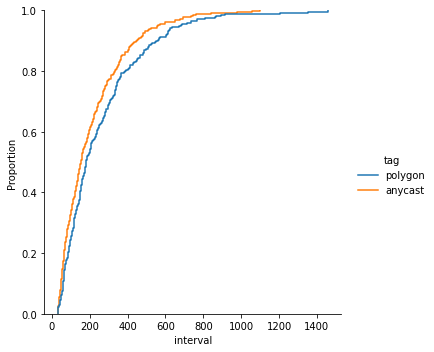

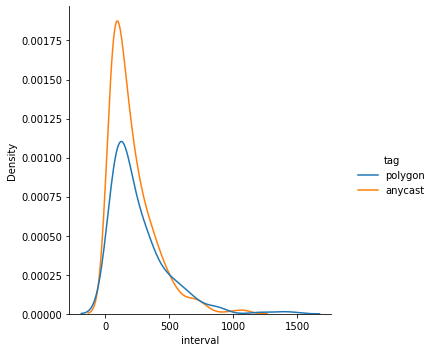

In [9]:
sns.displot(data=intervals, x='interval', hue='tag', kind="ecdf")
sns.displot(data=intervals, x='interval', hue='tag', kind="kde")
# plt.xlim(0,1300)

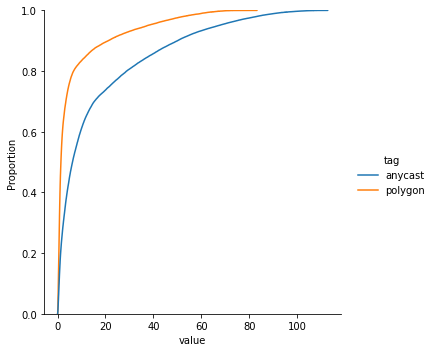

In [10]:
sns.displot(data=data, x='value', hue='tag', kind="ecdf")
# plt.xlim(0,1300)


In [11]:
cumulation = []
keep = []
new = []
end = []

data['st_int'] = data['st_timestamp'].values.astype(np.int64)
data['en_int'] = data['en_timestamp'].values.astype(np.int64)
for tag in ['polygon', 'anycast']:
    tmp_client = data[(data['tag'] == tag)]
    tmp_client = tmp_client.sort_values(by=['st_int'])
    count_c = 0
    min_t, max_t = int(min(tmp_client['st_int'])), int(max(tmp_client['st_int']))
    for t in tqdm(range(min_t, max_t)):
        count_last = len(tmp_client)
        tmp_client = tmp_client[(tmp_client['en_int'] > t)]
        count = count_last - len(tmp_client)
        
        count_c += count
        cumulation.append([tag, t-min_t, count_c])

#         item = (tmp_client['st_int'] < t) & (data['en_int'] > t)
#         count = sum(item)
#         keep.append([tag, t-min_t, count])


#         item = (tmp_client['st_int'] == t)
#         count = sum(item)
#         new.append([tag, t-min_t, count])


#         item = (tmp_client['en_int'] == t)
#         count = sum(item)
#         end.append([tag, t-min_t, count])
        
cumulation = pd.DataFrame(cumulation, columns=['tag', 't', 'count'])
keep = pd.DataFrame(keep, columns=['tag', 't', 'count'])
new = pd.DataFrame(new, columns=['tag', 't', 'count'])
end = pd.DataFrame(end, columns=['tag', 't', 'count'])

100%|██████████| 1709/1709 [00:02<00:00, 837.20it/s] 


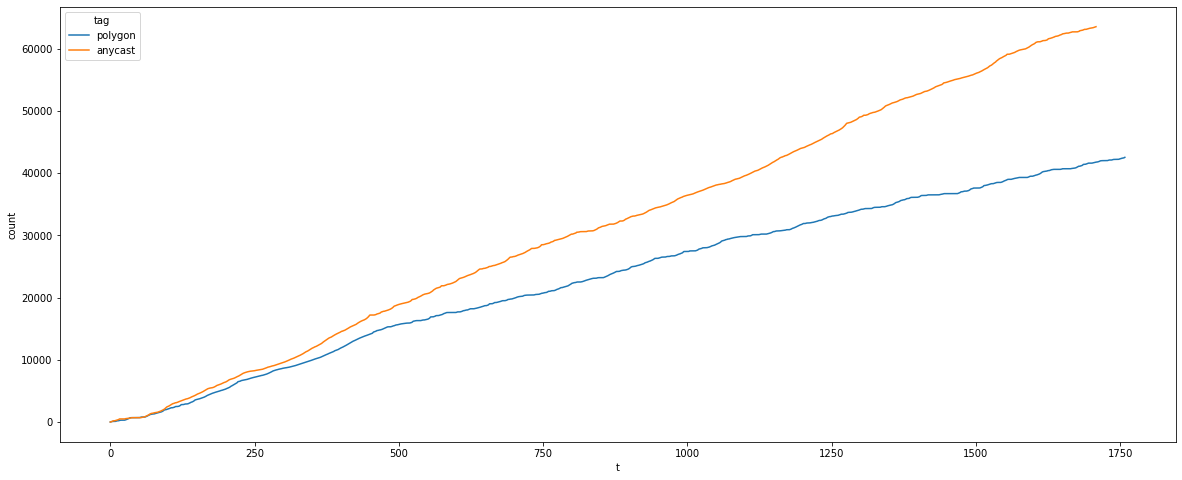

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(data=cumulation, x='t', y='count', hue='tag')
# get_point_value(g)

In [169]:
keep = []
new = []
end = []

for tag in ['polygon', 'anycast']:
    tmp = data_detail[data_detail['tag'] == tag]
    tmp_client = tmp.sort_values(by=['en_timestamp'])
    tmp_client['st_int'] = tmp_client['st_timestamp'].values.astype(np.int64)
    tmp_client['en_int'] = tmp_client['en_timestamp'].values.astype(np.int64)

    for t in range(int(min(tmp_client['st_timestamp'])), int(max(tmp_client['st_timestamp']))):
        item = (tmp_client['st_timestamp'] < t) & (tmp_client['en_timestamp'] > t)
        count = sum(item)
        keep.append([tag, t-int(min(tmp_client['st_timestamp'])), count])
        
        
        item = (tmp_client['st_int'] == t)
        count = sum(item)
        new.append([tag, t-int(min(tmp_client['st_timestamp'])), count])
        
        
        item = (tmp_client['en_int'] == t)
        count = sum(item)
        end.append([tag, t-int(min(tmp_client['st_timestamp'])), count])
        
keep = pd.DataFrame(keep, columns=['tag', 't', 'count'])
new = pd.DataFrame(new, columns=['tag', 't', 'count'])
end = pd.DataFrame(end, columns=['tag', 't', 'count'])

In [480]:
cumulation = []
keep = []
new = []
end = []


data['st_int'] = data['st_timestamp'].values.astype(np.int64)
data['en_int'] = data['en_timestamp'].values.astype(np.int64)
for tag in ['polygon', 'anycast']:
    tmp_tag = data[(data['tag'] == tag)]
    min_t, max_t = int(min(tmp_tag['st_int'])), int(min(tmp_tag['st_int'])) + 1000
    print(min_t, max_t, max_t-min_t)
    for client in set(tmp_tag['client']):
        tmp_client = tmp_tag[(tmp_tag['client'] == client)]
        tmp_client = tmp_client.sort_values(by=['st_int'])

        for t in range(min_t, max_t, 10):
            item = (tmp_client['en_int'] < t)
            count = sum(item)
            cumulation.append([tag, client, t-min_t, count])

            item = (tmp_client['st_int'] < t) & (tmp_client['en_int'] > t)
            count = sum(item)
            keep.append([tag, client, t-min_t, count])


            item = (tmp_client['st_int'] == t)
            count = sum(item)
            new.append([tag, client, t-min_t, count])


            item = (tmp_client['en_int'] == t)
            count = sum(item)
            end.append([tag, client, t-min_t, count])
        
cumulation = pd.DataFrame(cumulation, columns=['tag','client', 't', 'count'])
keep = pd.DataFrame(keep, columns=['tag','client', 't', 'count'])
new = pd.DataFrame(new, columns=['tag','client', 't', 'count'])
end = pd.DataFrame(end, columns=['tag','client', 't', 'count'])

1652763320 1652764320 1000
1652887779 1652888779 1000


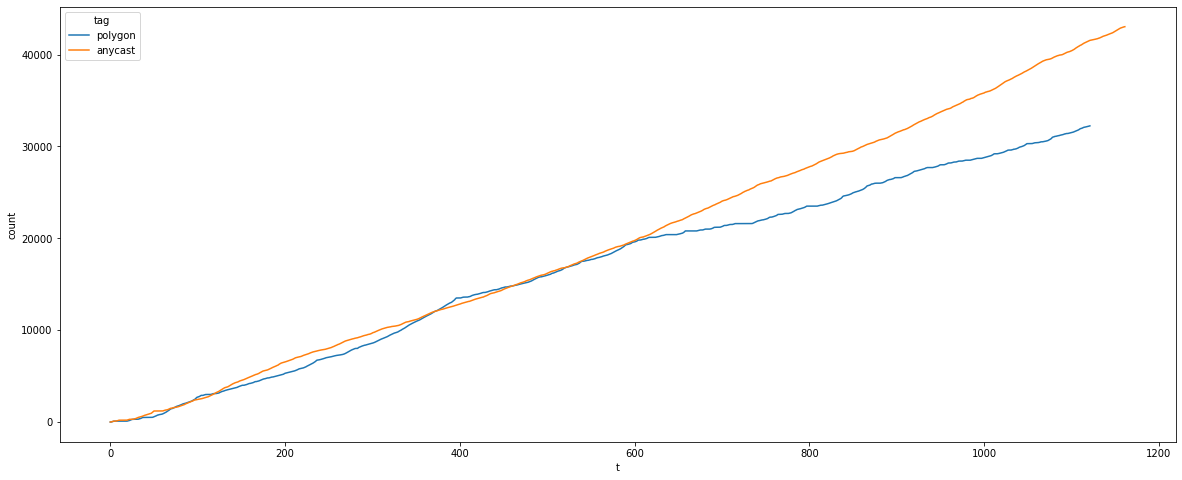

In [407]:
d = []
for tag in ['polygon', 'anycast']:
    tmp_tag = cumulation[(cumulation['tag'] == tag)]
    tmp_tag = tmp_tag.sort_values(by=['t'])
    for t in range(min(tmp_tag['t']), max(tmp_tag['t'])):
        tmp = tmp_tag[tmp_tag['t'] == t]
        d.append([tag, t, sum(tmp['count'])])
d = pd.DataFrame(d, columns=['tag', 't', 'count'])


fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(data=d, x='t', y='count', hue='tag')
# get_point_value(g)

In [408]:
polygon = cumulation[cumulation['tag'] == 'polygon']
polygon = polygon.sort_values(by=['t'])

anycast = cumulation[cumulation['tag'] == 'anycast']
anycast = anycast.sort_values(by=['t'])

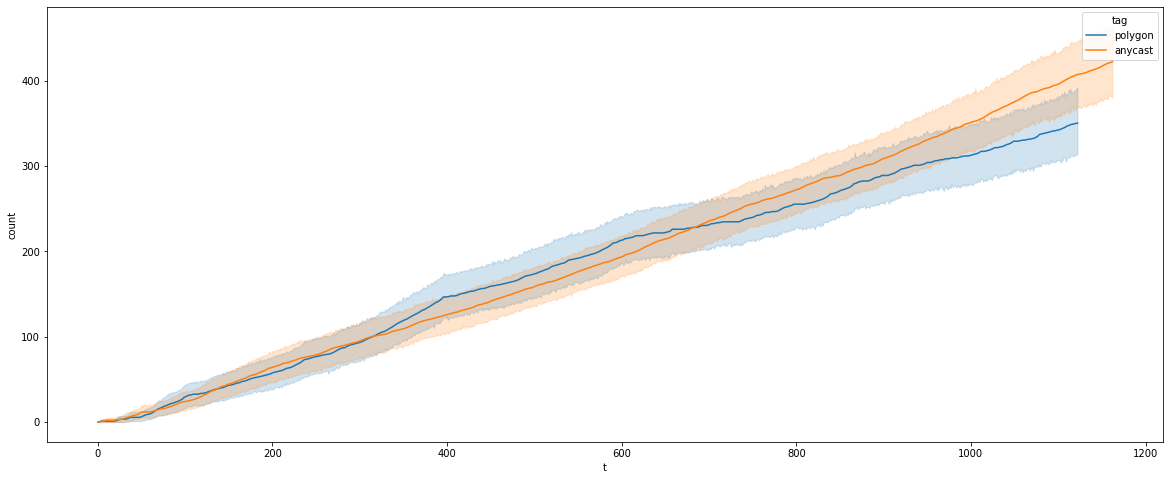

In [411]:
fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(data=cumulation, x='t', y='count', hue='tag')
# get_point_value(g)

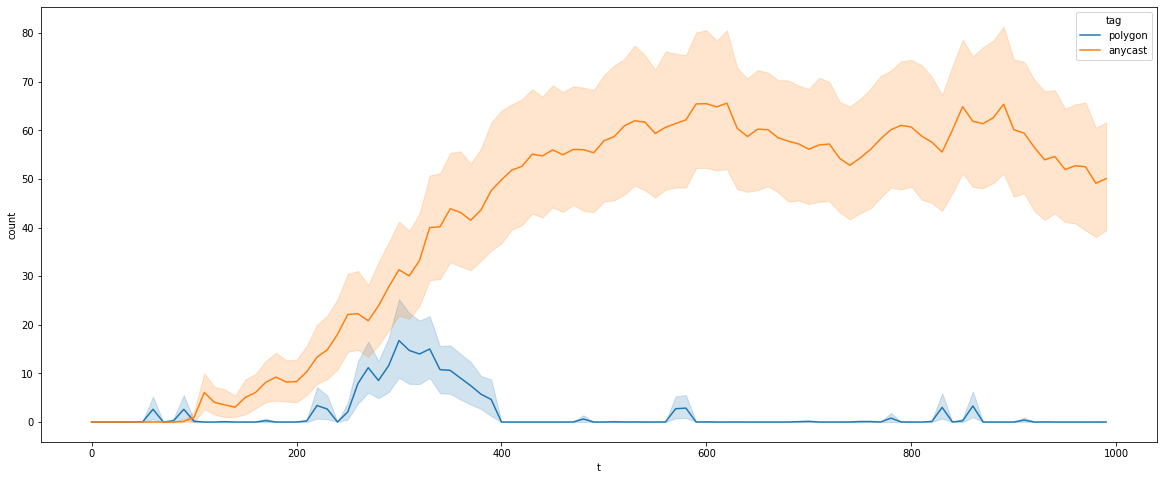

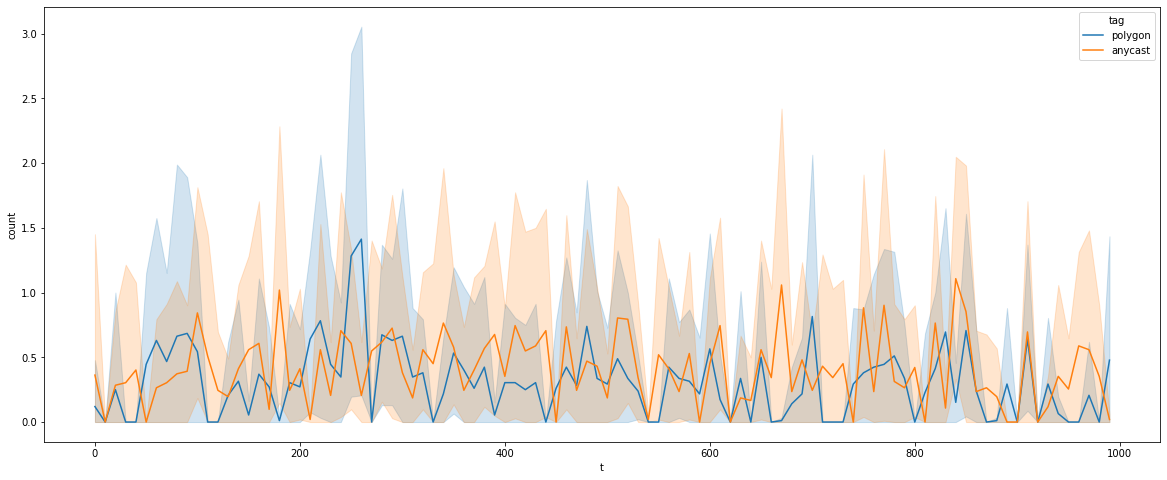

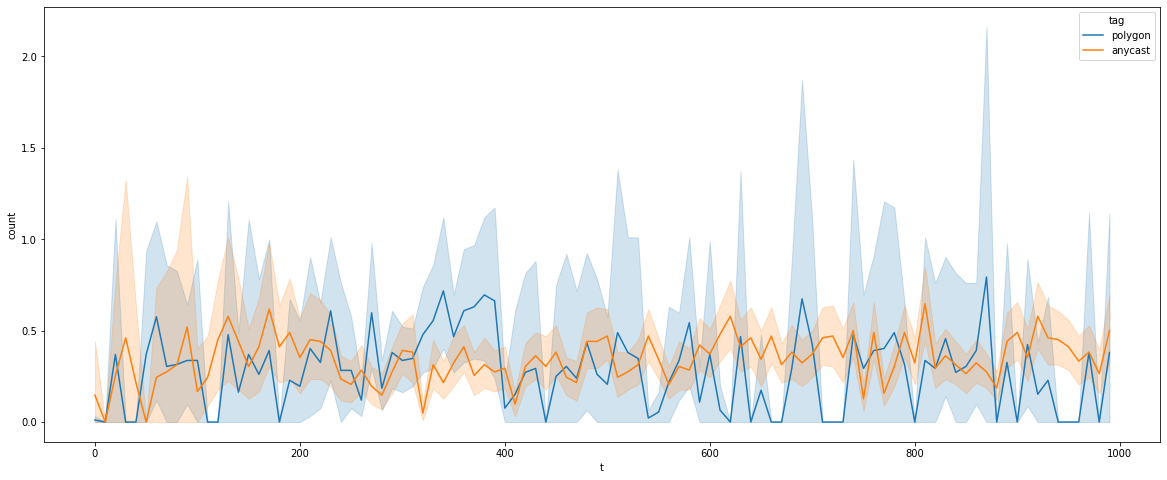

In [423]:
fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(data=keep, x='t', y='count', hue='tag')
# get_point_value(g)


fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(data=new, x='t', y='count', hue='tag')
# get_point_value(g)


fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(data=end, x='t', y='count', hue='tag')
# get_point_value(g)

In [424]:
polygon = new[new['tag'] == 'polygon']
polygon = polygon.sort_values(by=['t'])

anycast = new[new['tag'] == 'anycast']
anycast = anycast.sort_values(by=['t'])

In [425]:
sum(anycast['count']) / len(anycast), sum(polygon['count']) / len(polygon)

(0.4069607843137255, 0.30543478260869567)

In [444]:
cumulation = []
keep = []
new = []
end = []

input_data = all_new

input_data['st_int'] = input_data['st_timestamp'].values.astype(np.int64)
for tag in ['polygon', 'anycast']:
    tmp_tag = input_data[(input_data['tag'] == tag)]
    min_t, max_t = int(min(tmp_tag['st_int'])), int(min(tmp_tag['st_int'])) + 1000
    print(min_t, max_t, max_t-min_t)
    for client in set(tmp_tag['client']):
        tmp_client = tmp_tag[(tmp_tag['client'] == client)]
        tmp_client = tmp_client.sort_values(by=['st_int'])

        for t in range(min_t, max_t, 1):
            item = (tmp_client['st_int'] == t)
            count = sum(item)
            new.append([tag, client, t-min_t, count])

new = pd.DataFrame(new, columns=['tag','client', 't', 'count'])

1652763319 1652764319 1000
1652887777 1652888777 1000


In [448]:
polygon = new[new['tag'] == 'polygon']
polygon = polygon.sort_values(by=['t'])

anycast = new[new['tag'] == 'anycast']
anycast = anycast.sort_values(by=['t'])

In [441]:
sum(anycast['count']) / len(anycast), sum(polygon['count']) / len(polygon)

(0.0045098039215686276, 0.004536082474226804)

In [442]:
sum(anycast['count']), sum(polygon['count'])

(46, 44)

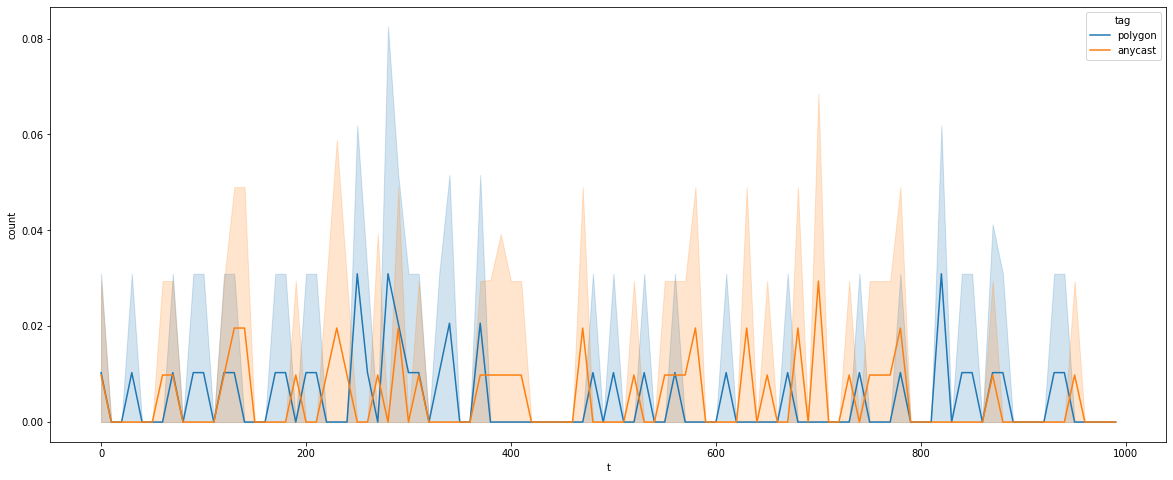

In [439]:
fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(data=new, x='t', y='count', hue='tag')
# get_point_value(g)


In [449]:
sum(anycast['count']), sum(polygon['count'])

(446, 366)

In [454]:
polygon = all_new[all_new['tag'] == 'polygon']
# polygon = polygon.sort_values(by=['t'])

anycast = all_new[all_new['tag'] == 'anycast']
# anycast = anycast.sort_values(by=['t'])

In [459]:
[len(anycast) / (max(anycast['st_timestamp']) - min(anycast['st_timestamp'])), 
 len(polygon) / (max(polygon['st_timestamp']) - min(polygon['st_timestamp']))]

[0.43496985357450474, 0.35892857142857143]

In [473]:
cumulation = []
keep = []
new = []
end = []

dict_type = {0: 'other',
            1: 'cpu'}

for i, input_data in enumerate([data, data_other_type]):
    input_data['st_int'] = input_data['st_timestamp'].values.astype(np.int64)
    for tag in ['polygon', 'anycast']:
        tmp_tag = input_data[(input_data['tag'] == tag)]
        tmp_tag = tmp_tag.sort_values(by=['st_int'])
        count_c = 0
    #     min_t, max_t = int(min(tmp_tag['st_int'])), int(max(tmp_tag['st_int']))
        min_t, max_t = int(min(tmp_tag['st_int'])), int(min(tmp_tag['st_int'])) + 1000
        for t in tqdm(range(min_t, max_t, 5)):
            count_last = len(tmp_tag)
            tmp_tag = tmp_tag[(tmp_tag['st_int'] > t)]
            count = count_last - len(tmp_tag)

            count_c += count
            cumulation.append([dict_type[i], tag, t-min_t, count_c])

cumulation = pd.DataFrame(cumulation, columns=['type','tag', 't', 'count'])


100%|██████████| 200/200 [00:00<00:00, 1131.84it/s]A

100%|██████████| 200/200 [00:00<00:00, 921.43it/s]

100%|██████████| 200/200 [00:00<00:00, 2534.84it/s]

100%|██████████| 200/200 [00:00<00:00, 2497.35it/s]


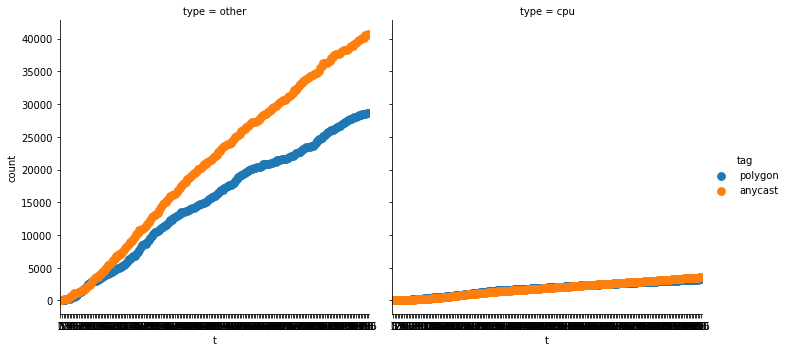

In [474]:
# fig, ax = plt.subplots(figsize=(20, 8))
g = sns.catplot(data=cumulation, kind='point',
                x='t', y='count', hue='tag', col='type')
# get_point_value(g)

In [475]:
cumulation = []
keep = []
new = []
end = []

dict_type = {0: 'cpu'}

for i, input_data in enumerate([data]):
    input_data['st_int'] = input_data['st_timestamp'].values.astype(np.int64)
    input_data['en_int'] = input_data['en_timestamp'].values.astype(np.int64)
    for tag in ['polygon', 'anycast']:
        tmp_tag = input_data[(input_data['tag'] == tag)]
        tmp_tag = tmp_tag.sort_values(by=['st_int'])
        tmp_tag_end = deepcopy(tmp_tag)
        count_c = 0
        count_c_end = 0
    #     min_t, max_t = int(min(tmp_tag['st_int'])), int(max(tmp_tag['st_int']))
        min_t, max_t = int(min(tmp_tag['st_int'])), int(min(tmp_tag['st_int'])) + 1000
        for t in tqdm(range(min_t, max_t, 5)):
            count_last = len(tmp_tag)
            tmp_tag = tmp_tag[(tmp_tag['st_int'] > t)]
            count = count_last - len(tmp_tag)

            count_c += count
            cumulation.append([dict_type[i], tag, t-min_t, count_c])
            
            

            count_last = len(tmp_tag_end)
            tmp_tag_end = tmp_tag_end[(tmp_tag_end['en_int'] > t)]
            count = count_last - len(tmp_tag_end)

            count_c_end += count
            end.append([dict_type[i], tag, t-min_t, count_c])
            


cumulation = pd.DataFrame(cumulation, columns=['type','tag', 't', 'count'])
end = pd.DataFrame(end, columns=['type','tag', 't', 'count'])


100%|██████████| 200/200 [00:00<00:00, 590.65it/s]

100%|██████████| 200/200 [00:00<00:00, 454.42it/s]


In [476]:
end

,type,tag,t,count
0,cpu,polygon,0,11
1,cpu,polygon,5,100
2,cpu,polygon,10,100
3,cpu,polygon,15,100
4,cpu,polygon,20,161
...,...,...,...,...
395,cpu,anycast,975,40096
396,cpu,anycast,980,40148
397,cpu,anycast,985,40572
398,cpu,anycast,990,40598


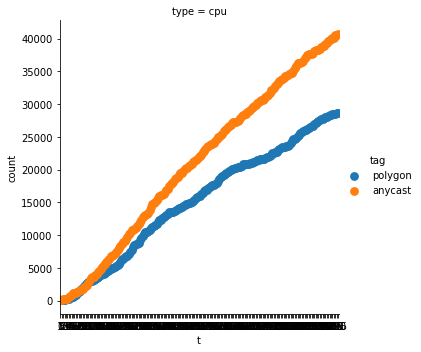

In [477]:
# fig, ax = plt.subplots(figsize=(20, 8))
g = sns.catplot(data=end, kind='point',
                x='t', y='count', hue='tag', col='type')
# get_point_value(g)

In [482]:
keep.to_csv('keep.csv', index=None)

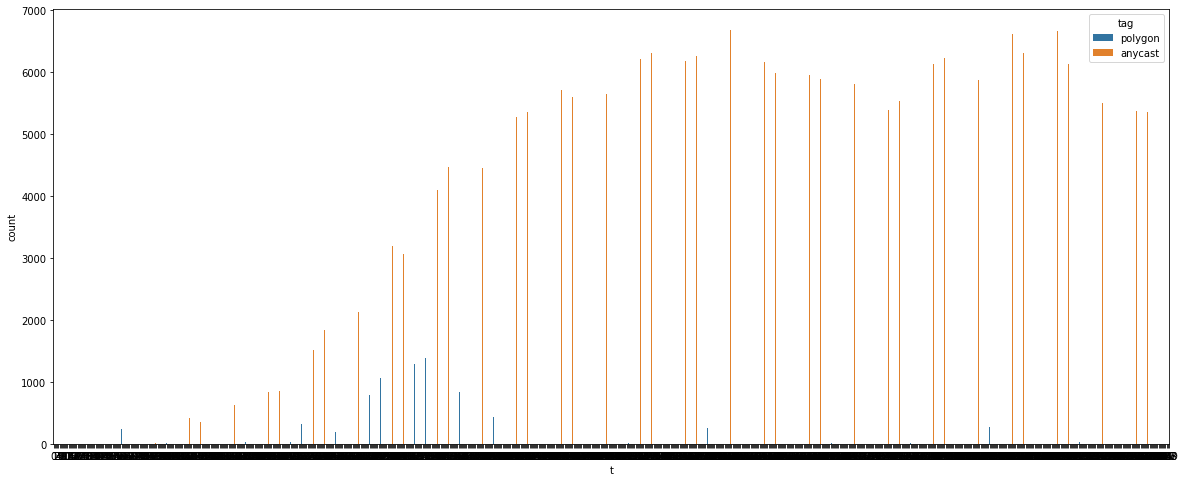

In [485]:
d = []
for tag in ['polygon', 'anycast']:
    tmp_tag = keep[(keep['tag'] == tag)]
    tmp_tag = tmp_tag.sort_values(by=['t'])
    for t in range(min(tmp_tag['t']), max(tmp_tag['t'])):
        tmp = tmp_tag[tmp_tag['t'] == t]
        d.append([tag, t, sum(tmp['count'])])
d = pd.DataFrame(d, columns=['tag', 't', 'count'])


fig, ax = plt.subplots(figsize=(20, 8))
g = sns.barplot(data=d, x='t', y='count', hue='tag')
# get_point_value(g)

In [688]:
# polygon['10'] = (polygon['st_timestamp'] - min(polygon['st_timestamp']) ) // 10
# polygon = polygon.sort_values(by=['st_timestamp'])
# anycast['10'] = (anycast['st_timestamp'] - min(anycast['st_timestamp']) ) // 10
# anycast = anycast.sort_values(by=['st_timestamp'])

# d = pd.concat([anycast, polygon])

# # fig, ax = plt.subplots(figsize=(20, 8))
# g = sns.catplot(data=d, kind='count',
#                 x='10', hue='request_type', col='tag')
# # get_point_value(g)

In [689]:
# g = sns.catplot(data=d[d['10'] < 1000], kind='count',
#                 x='10', 
#                 hue='tag',
#                 col='request_type')


In [695]:
polygon = data_all_type[data_all_type['tag'] == 'polygon']
polygon = polygon.sort_values(by=['st_timestamp'])
polygon['grid'] = (polygon['st_timestamp'] - min(polygon['st_timestamp']) ) // 5

anycast = data_all_type[data_all_type['tag'] == 'anycast']
anycast = anycast.sort_values(by=['st_timestamp'])
anycast['grid'] = (anycast['st_timestamp'] - min(anycast['st_timestamp']) ) // 5

d = pd.concat([anycast, polygon])

d.to_csv('all_type.csv', index=None)

In [696]:
d_cumulation = []
for tag in ['polygon', 'anycast']:
    tmp_tag = d[(d['tag'] == tag)]
    tmp_tag = tmp_tag.sort_values(by=['grid'])
    for t in range(min(tmp_tag['grid']), max(tmp_tag['grid'])):
        tmp = tmp_tag[tmp_tag['grid'] == t]
        d_cumulation.append([tag, t, len(tmp)])
d_cumulation = pd.DataFrame(d_cumulation, columns=['tag', 'grid', 'count'])



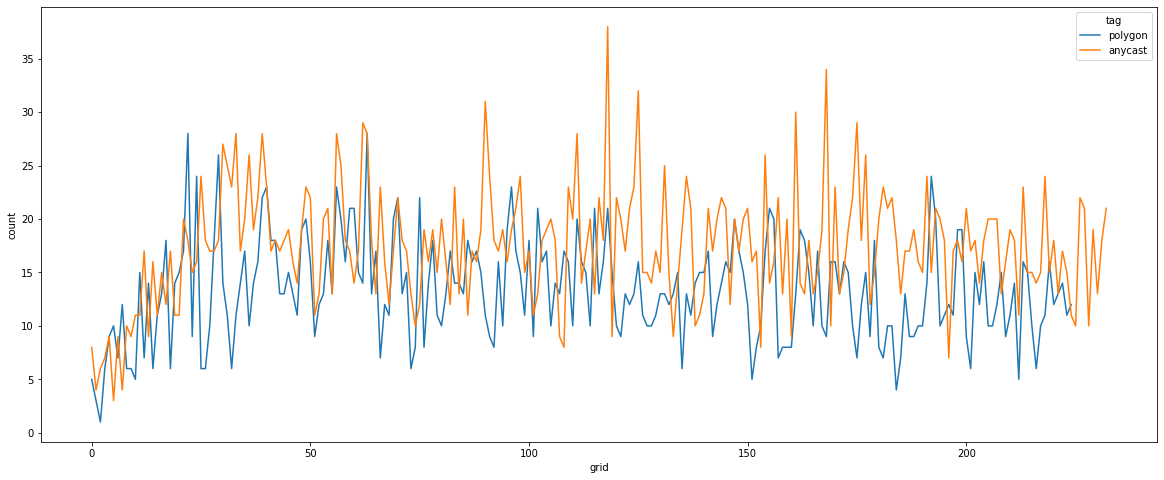

In [697]:
fig, ax = plt.subplots(figsize=(20, 8))
g = sns.lineplot(data=d_cumulation,
                x='grid', 
                  y='count',
                hue='tag')


In [667]:
polygon = data_all_ok_type[data_all_ok_type['tag'] == 'polygon']
polygon = polygon.sort_values(by=['st_timestamp'])
polygon['grid'] = (polygon['st_timestamp'] - min(polygon['st_timestamp']) ) // 5

anycast = data_all_ok_type[data_all_ok_type['tag'] == 'anycast']
anycast = anycast.sort_values(by=['st_timestamp'])
anycast['grid'] = (anycast['st_timestamp'] - min(anycast['st_timestamp']) ) // 5

d = pd.concat([anycast, polygon])


# for client in range(1,100,5):

small_diff = []
for client in set(d['client']):
    client = str(client)
    input_data = d
    selected_data = []

    for tag in ['polygon', 'anycast']:
        tmp_tag = input_data[(input_data['tag'] == tag) & (input_data['client'] == client)]
        tmp_tag = tmp_tag.sort_values(by=['grid'])

        tmp = deepcopy(tmp_tag)
        tmp['st_offset'] = tmp['st_timestamp'] - min(tmp_tag['st_timestamp'])
#         print(max(tmp['st_offset']))

        if len(selected_data) == 0:
            selected_data = tmp
        else:
            selected_data = pd.concat([selected_data, tmp])
            
    p_max = max(selected_data[selected_data['tag'] == 'polygon']['st_offset'])
    a_max = max(selected_data[selected_data['tag'] == 'anycast']['st_offset'])
    if p_max < a_max:
        ratio = p_max / a_max
    if p_max > a_max:
        ratio = a_max / p_max
    if ratio > 0.8:
#         print(ratio)
        if len(small_diff) == 0:
            small_diff = selected_data
        else:
            small_diff = pd.concat([small_diff, selected_data])
#     print(client, p_max, a_max)
    dict_y = {"polygon": 0.5,
             'anycast': 0.5}

    continue
    
    
    for tag in ['polygon', 'anycast']:
        fig, ax = plt.subplots(figsize=(20, 2))
        tmp_tag = selected_data[selected_data['tag'] == tag]
        max_t = max(tmp_tag['st_offset'])

        last = 0
        scatter_point_x = []
        for i, item in enumerate(tmp_tag.values):
            if item[2] == 'video':
                c = 'red'
            if item[2] == 'cpu':
                c = 'blue'
            if item[2] == 'normal_1':
                c = 'green'

            st_offset = (item[-1] / max_t)
            if (p_max > a_max) and tag == 'anycast':
                st_offset = st_offset * ratio
            if (p_max < a_max) and tag == 'polygon':
                st_offset = st_offset * ratio
                
            plt.scatter(st_offset, dict_y[tag], color=c)
            plt.axhline(y=dict_y[tag], xmin=last, xmax=st_offset, color=c)
#             print(last, st_offset, c)
            last = st_offset
#             if i > 4:
#                 break
    #         print(last, st_offset)
#         plt.text(0.5, dict_y[tag] + 0.1,tag)

        plt.ylim(0.4,0.6)
        plt.xlim(0,1)
        plt.show()


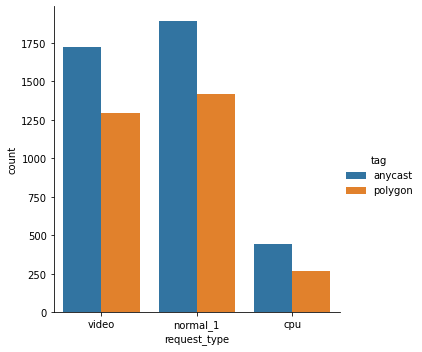

In [700]:
sns.catplot(data=d, kind='count', x='request_type', hue='tag')

1653924161 1653925161 1000
1653917186 1653918186 1000


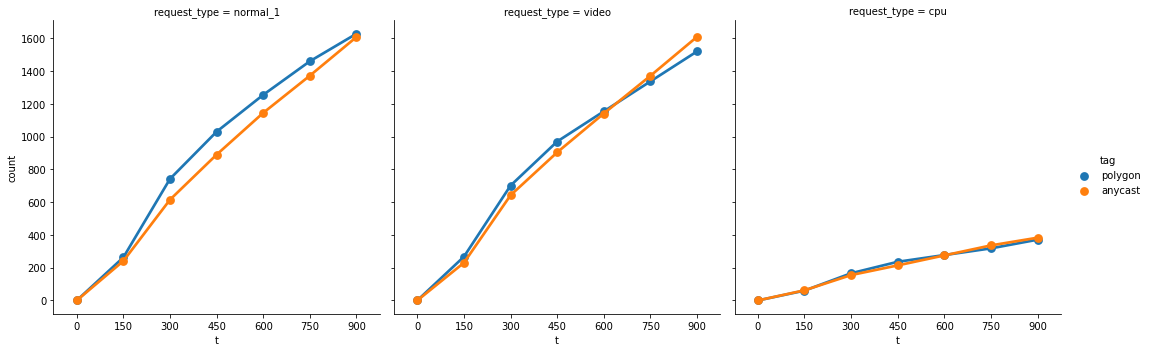

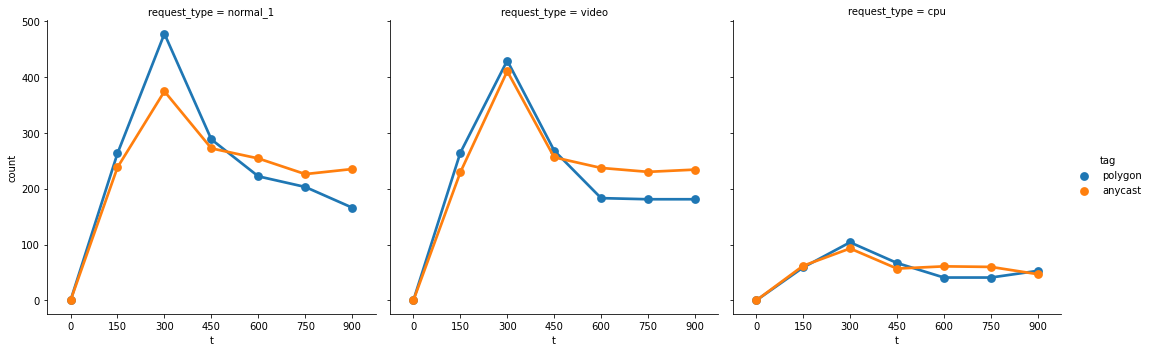

In [15]:
cumulation = []
keep = []
new = []
end = []

input_data = data_all

input_data['st_int'] = input_data['st_timestamp'].values.astype(np.int64)
# input_data['en_int'] = input_data['en_timestamp'].values.astype(np.int64)
for tag in ['polygon', 'anycast']:
    tmp_tag = input_data[(input_data['tag'] == tag)]
    min_t, max_t = int(min(tmp_tag['st_int'])), int(min(tmp_tag['st_int'])) + 1000
    print(min_t, max_t, max_t-min_t)
#     for client in set(tmp_tag['client']):
#         tmp_client = tmp_tag[(tmp_tag['client'] == client)]
#         tmp_client = tmp_client.sort_values(by=['st_int'])
        
    for request_type in set(input_data['request_type']):
        tmp_type = tmp_tag[tmp_tag['request_type'] == request_type]

        step = 150
        for t in range(min_t, max_t, step):
            item = (tmp_type['st_int'] < t)
            count = sum(item)
            cumulation.append([tag, client, t-min_t, request_type, count])

#             item = (tmp_type['st_int'] < t) & (tmp_type['en_int'] > t)
#             count = sum(item)
#             keep.append([tag, client, t-min_t, count])


            item = (tmp_type['st_int'] > t-step) & (tmp_type['st_int'] < t)
            count = sum(item)
            new.append([tag, client, t-min_t, request_type, count])


#             item = (tmp_type['en_int'] == t)
#             count = sum(item)
#             end.append([tag, client, t-min_t, count])
        
cumulation = pd.DataFrame(cumulation, columns=['tag','client', 't', 'request_type', 'count'])
# keep = pd.DataFrame(keep, columns=['tag','client', 't', 'count'])
new = pd.DataFrame(new, columns=['tag','client', 't', 'request_type', 'count'])
# end = pd.DataFrame(end, columns=['tag','client', 't', 'count'])


# fig, ax = plt.subplots(figsize=(20, 8))
g = sns.catplot(data=cumulation, kind='point',
                x='t', y='count', hue='tag',col='request_type')
# get_point_value(g)

# fig, ax = plt.subplots(figsize=(20, 8))
g = sns.catplot(data=new, kind='point',
                x='t', y='count', hue='tag',col='request_type')
# get_point_value(g)

hue: polygon
[  0.  60. 166. 236. 277. 318. 371.]
[  0. 236. 371.]
hue: anycast
[  0.  62. 155. 214. 275. 336. 383.]
[  0. 214. 383.]


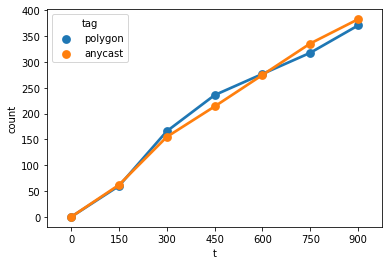

hue: polygon
[  0.  59. 104.  67.  41.  41.  53.]
[  0.  53. 104.]
hue: anycast
[ 0. 62. 93. 57. 61. 60. 47.]
[ 0. 60. 93.]


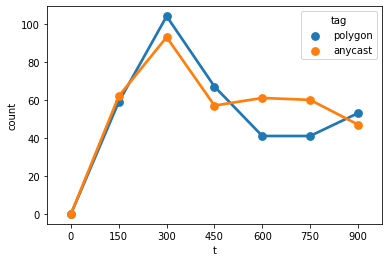

In [16]:
g = sns.pointplot(data=cumulation[cumulation['request_type'] == 'cpu' ],
                x='t', y='count', hue='tag')
get_point_value(g)
plt.show()

g = sns.pointplot(data=new[new['request_type'] == 'cpu' ],
                x='t', y='count', hue='tag')
get_point_value(g)

1652763316 1652764316 1000
1652887768 1652888768 1000


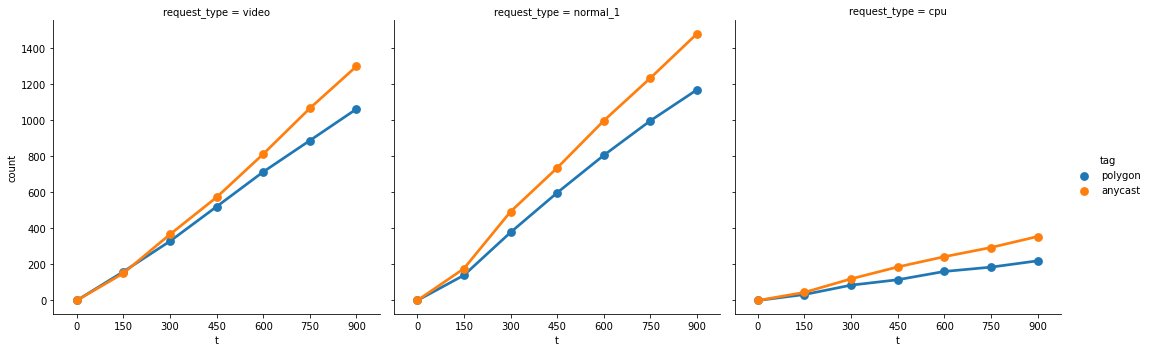

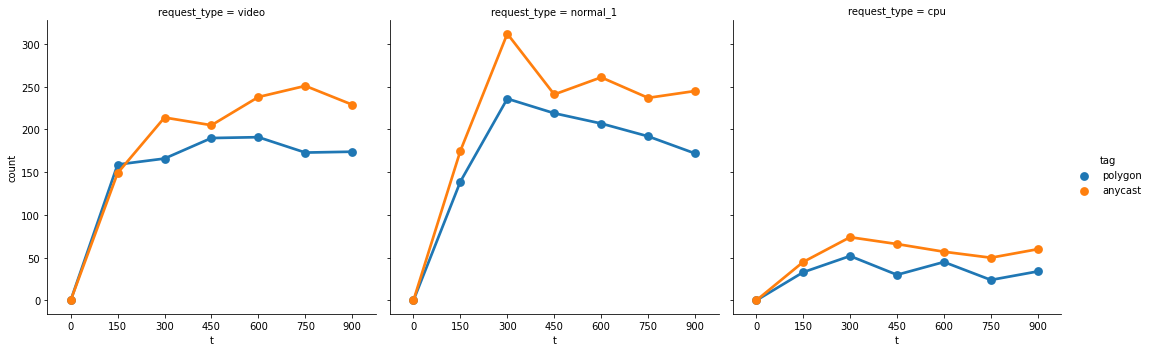

In [824]:
cumulation = []
keep = []
new = []
end = []

input_data = data_all_ok_type

input_data['st_int'] = input_data['st_timestamp'].values.astype(np.int64)
# input_data['en_int'] = input_data['en_timestamp'].values.astype(np.int64)
for tag in ['polygon', 'anycast']:
    tmp_tag = input_data[(input_data['tag'] == tag)]
    min_t, max_t = int(min(tmp_tag['st_int'])), int(min(tmp_tag['st_int'])) + 1000
    print(min_t, max_t, max_t-min_t)
#     for client in set(tmp_tag['client']):
#         tmp_client = tmp_tag[(tmp_tag['client'] == client)]
#         tmp_client = tmp_client.sort_values(by=['st_int'])
        
    for request_type in set(input_data['request_type']):
        tmp_type = tmp_tag[tmp_tag['request_type'] == request_type]

        step = 150
        for t in range(min_t, max_t, step):
            item = (tmp_type['st_int'] < t)
            count = sum(item)
            cumulation.append([tag, client, t-min_t, request_type, count])

#             item = (tmp_type['st_int'] < t) & (tmp_type['en_int'] > t)
#             count = sum(item)
#             keep.append([tag, client, t-min_t, count])


            item = (tmp_type['st_int'] > t-step) & (tmp_type['st_int'] < t)
            count = sum(item)
            new.append([tag, client, t-min_t, request_type, count])


#             item = (tmp_client['en_int'] == t)
#             count = sum(item)
#             end.append([tag, client, t-min_t, count])
        
cumulation = pd.DataFrame(cumulation, columns=['tag','client', 't', 'request_type', 'count'])
# keep = pd.DataFrame(keep, columns=['tag','client', 't', 'count'])
new = pd.DataFrame(new, columns=['tag','client', 't', 'request_type', 'count'])
# end = pd.DataFrame(end, columns=['tag','client', 't', 'count'])


# fig, ax = plt.subplots(figsize=(20, 8))
g = sns.catplot(data=cumulation, kind='point',
                x='t', y='count', hue='tag',col='request_type')
# get_point_value(g)

# fig, ax = plt.subplots(figsize=(20, 8))
g = sns.catplot(data=new, kind='point',
                x='t', y='count', hue='tag',col='request_type')
# get_point_value(g)

hue: polygon
[ 0. 33. 52. 30. 45. 24. 34.]
[ 0. 33. 52.]
hue: anycast
[ 0. 45. 74. 66. 57. 50. 60.]
[ 0. 57. 74.]


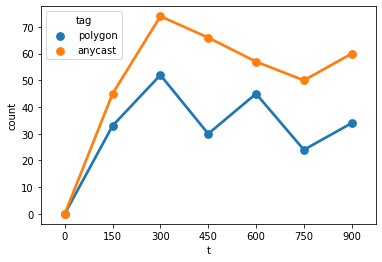

In [825]:
g = sns.pointplot(data=new[new['request_type'] == 'cpu' ],
                x='t', y='count', hue='tag')
get_point_value(g)

1653924161 1653925161 1000
1653917189 1653918189 1000


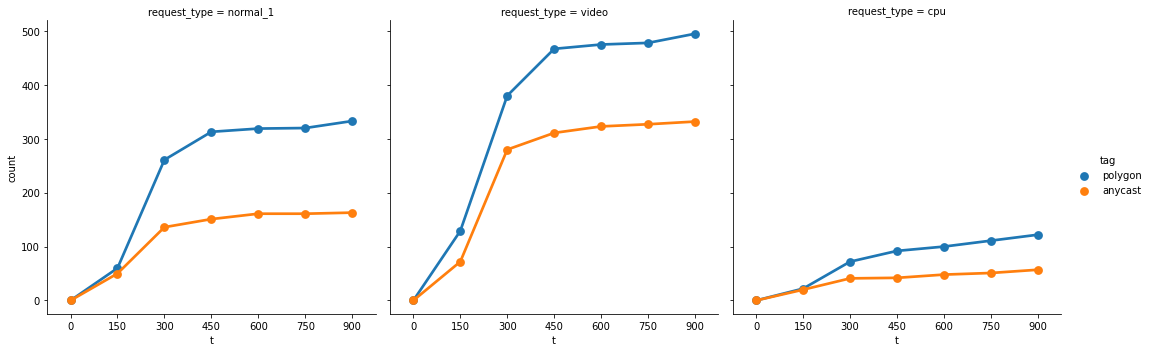

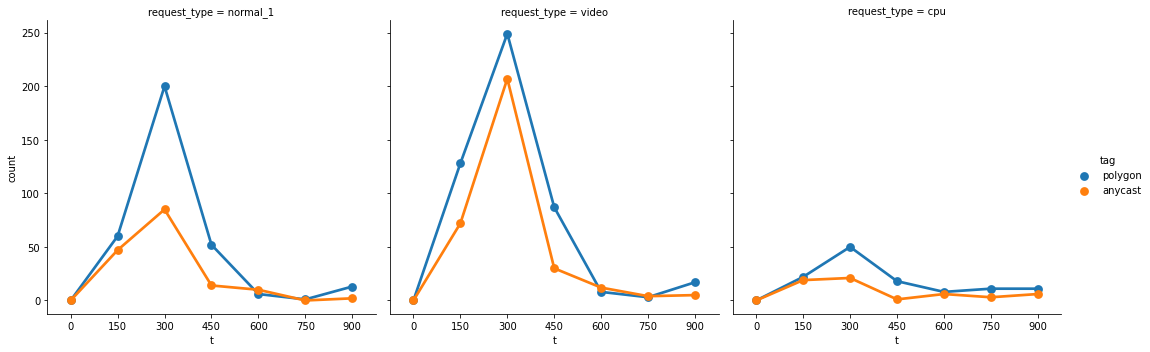

In [13]:
cumulation = []
keep = []
new = []
end = []

input_data = error_time_list

input_data['st_int'] = input_data['st_timestamp'].values.astype(np.int64)
# input_data['en_int'] = input_data['en_timestamp'].values.astype(np.int64)
for tag in ['polygon', 'anycast']:
    tmp_tag = input_data[(input_data['tag'] == tag)]
    min_t, max_t = int(min(tmp_tag['st_int'])), int(min(tmp_tag['st_int'])) + 1000
    print(min_t, max_t, max_t-min_t)
#     for client in set(tmp_tag['client']):
#         tmp_client = tmp_tag[(tmp_tag['client'] == client)]
#         tmp_client = tmp_client.sort_values(by=['st_int'])
        
    for request_type in set(input_data['request_type']):
        tmp_type = tmp_tag[tmp_tag['request_type'] == request_type]

        step = 150
        for t in range(min_t, max_t, step):
            item = (tmp_type['st_int'] < t)
            count = sum(item)
            cumulation.append([tag, client, t-min_t, request_type, count])

#             item = (tmp_type['st_int'] < t) & (tmp_type['en_int'] > t)
#             count = sum(item)
#             keep.append([tag, client, t-min_t, count])


            item = (tmp_type['st_int'] > t-step) & (tmp_type['st_int'] < t)
            count = sum(item)
            new.append([tag, client, t-min_t, request_type, count])



#             item = (tmp_client['en_int'] == t)
#             count = sum(item)
#             end.append([tag, client, t-min_t, count])
        
cumulation = pd.DataFrame(cumulation, columns=['tag','client', 't', 'request_type', 'count'])
# keep = pd.DataFrame(keep, columns=['tag','client', 't', 'count'])
new = pd.DataFrame(new, columns=['tag','client', 't', 'request_type', 'count'])
# end = pd.DataFrame(end, columns=['tag','client', 't', 'count'])


# fig, ax = plt.subplots(figsize=(20, 8))
g = sns.catplot(data=cumulation, kind='point',
                x='t', y='count', hue='tag',col='request_type')
# get_point_value(g)

# fig, ax = plt.subplots(figsize=(20, 8))
g = sns.catplot(data=new, kind='point',
                x='t', y='count', hue='tag',col='request_type')
# get_point_value(g)

hue: polygon
[ 0. 22. 50. 18.  8. 11. 11.]
[ 0. 11. 50.]
hue: anycast
[ 0. 19. 21.  1.  6.  3.  6.]
[ 0.  6. 21.]


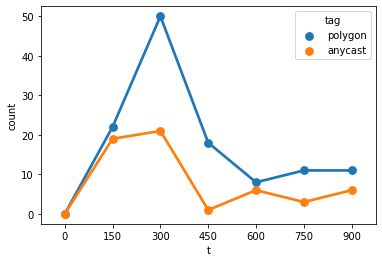

In [14]:
g = sns.pointplot(data=new[new['request_type'] == 'cpu' ],
                x='t', y='count', hue='tag')
get_point_value(g)

In [732]:
data_all_ok_type

,tag,client,request_type,st_timestamp,en_timestamp,st_int
0,anycast,85,normal_1,1652888458,1652888460,1652888458
1,anycast,85,normal_1,1652888028,1652888037,1652888028
2,anycast,85,normal_1,1652888673,1652888674,1652888673
3,anycast,85,normal_1,1652888171,1652888175,1652888171
4,anycast,85,video,1652888036,1652888140,1652888036
...,...,...,...,...,...,...
7035,polygon,78,normal_1,1652763953,1652763962,1652763953
7036,polygon,78,video,1652764373,1652764407,1652764373
7037,polygon,78,video,1652764438,1652764438,1652764438
7038,polygon,78,video,1652763648,1652763732,1652763648


In [736]:
data_cpu

,tag,client,st_timestamp,en_timestamp,value
0,anycast,85,1.652888e+09,1.652888e+09,1.186550
1,anycast,85,1.652888e+09,1.652888e+09,1.718125
2,anycast,85,1.652888e+09,1.652888e+09,2.681552
3,anycast,85,1.652888e+09,1.652889e+09,8.315350
4,anycast,85,1.652888e+09,1.652889e+09,10.983197
...,...,...,...,...,...
71481,polygon,78,1.652764e+09,1.652764e+09,0.839192
71482,polygon,78,1.652764e+09,1.652764e+09,0.702924
71483,polygon,78,1.652764e+09,1.652764e+09,0.780451
71484,polygon,78,1.652764e+09,1.652764e+09,0.915982


In [793]:
cumulation = []
keep = []
new = []
end = []

input_data = data_cpu

input_data['st_int'] = input_data['st_timestamp'].values.astype(np.int64)
input_data['en_int'] = input_data['en_timestamp'].values.astype(np.int64)
for tag in ['polygon', 'anycast']:
    tmp_tag = input_data[(input_data['tag'] == tag)]
    min_t, max_t = int(min(tmp_tag['st_int'])), int(min(tmp_tag['st_int'])) + 1000
    print(min_t, max_t, max_t-min_t)

    for t in range(min_t, max_t, 1):
#                 item = (tmp_type['st_int'] < t)
#                 count = sum(item)
#                 cumulation.append([tag, client, t-min_t, request_type, count])

#             item = (tmp_client['st_int'] < t) & (tmp_client['en_int'] > t)
#             count = sum(item)
#             keep.append([tag, client, t-min_t, count])


        item = (tmp_tag['st_int'] == t)
        count = sum(item)
        new.append([tag, client, t-min_t, count])


        item = (tmp_tag['en_int'] == t)
        count = sum(item)
        end.append([tag, client, t-min_t, count])
        
cumulation = pd.DataFrame(cumulation, columns=['tag','client', 't', 'request_type', 'count'])
keep = pd.DataFrame(keep, columns=['tag','client', 't', 'count'])
new = pd.DataFrame(new, columns=['tag','client', 't', 'count'])
end = pd.DataFrame(end, columns=['tag','client', 't', 'count'])

1652763323 1652764323 1000
1652887781 1652888781 1000


In [803]:
input_data = data_cpu

tmp_data = []
new = []
end = []

input_data['st_int'] = input_data['st_timestamp'].values.astype(np.int64)
input_data['en_int'] = input_data['en_timestamp'].values.astype(np.int64)
for tag in ['polygon', 'anycast']:
    tmp_tag = input_data[(input_data['tag'] == tag)]
    tmp_tag = tmp_tag.sort_values(by=['st_int'])
    min_t, max_t = int(min(tmp_tag['st_int'])), int(max(tmp_tag['st_int']))
    print(max_t - min_t)
    tmp_tag['st_int'] = tmp_tag['st_int'] - min_t
    tmp_tag['en_int'] = tmp_tag['en_int'] - min_t

    if len(tmp_data) == 0:
        tmp_data = tmp_tag
    else:
        tmp_data = pd.concat([tmp_data, tmp_tag])

1123
1163


In [805]:
split_t = 400

input_data = tmp_data

for tag in ['anycast', 'polygon']:
    tmp_tag = input_data[(input_data['tag'] == tag)]
    
    tmp_1 = tmp_tag[tmp_tag['st_int'] <= split_t]
    tmp_2 = tmp_tag[tmp_tag['st_int'] > split_t]
    print(tag, 
          len(tmp_1), len(tmp_2),
          np.mean(tmp_1['value']), np.mean(tmp_2['value']))

anycast 2652 41728 1.6153197986148242 112.74915641682234
polygon 2504 24602 2.710664557572752 5.972451453741542


In [831]:
polygon = data_all_ok_type[data_all_ok_type['tag'] == 'polygon']
polygon = polygon.sort_values(by=['st_timestamp'])
polygon['grid'] = (polygon['st_timestamp'] - min(polygon['st_timestamp']) ) // 5

anycast = data_all_ok_type[data_all_ok_type['tag'] == 'anycast']
anycast = anycast.sort_values(by=['st_timestamp'])
anycast['grid'] = (anycast['st_timestamp'] - min(anycast['st_timestamp']) ) // 5

d = pd.concat([anycast, polygon])


# for client in range(1,100,5):

small_diff = []
for client in set(d['client']):
    client = str(client)
    input_data = d
    selected_data = []

    for tag in ['polygon', 'anycast']:
        tmp_tag = input_data[(input_data['tag'] == tag) & (input_data['client'] == client)]
        tmp_tag = tmp_tag.sort_values(by=['grid'])

        tmp = deepcopy(tmp_tag)
        tmp['st_offset'] = tmp['st_timestamp'] - min(tmp_tag['st_timestamp'])

        if len(selected_data) == 0:
            selected_data = tmp
        else:
            selected_data = pd.concat([selected_data, tmp])
            
    p_max = max(selected_data[selected_data['tag'] == 'polygon']['st_offset'])
    a_max = max(selected_data[selected_data['tag'] == 'anycast']['st_offset'])
    if p_max < a_max:
        ratio = p_max / a_max
    if p_max > a_max:
        ratio = a_max / p_max
    if ratio > 0.8:
        if len(small_diff) == 0:
            small_diff = selected_data
        else:
            small_diff = pd.concat([small_diff, selected_data])
    dict_y = {"polygon": 0.5,
             'anycast': 0.5}

    continue
    
    
    for tag in ['polygon', 'anycast']:
        fig, ax = plt.subplots(figsize=(20, 2))
        tmp_tag = selected_data[selected_data['tag'] == tag]
        max_t = max(tmp_tag['st_offset'])

        scatter_point_x = []
        for i, item in enumerate(tmp_tag.values):
            if item[2] == 'video':
                c = 'red'
            if item[2] == 'cpu':
                c = 'blue'
            if item[2] == 'normal_1':
                c = 'green'

            st_offset = (item[-1] / max_t)
            if (p_max > a_max) and tag == 'anycast':
                st_offset = st_offset * ratio
            if (p_max < a_max) and tag == 'polygon':
                st_offset = st_offset * ratio
                
            plt.scatter(st_offset, dict_y[tag], color=c)
            plt.axhline(y=dict_y[tag], xmin=last, xmax=st_offset, color=c)
            last = st_offset
#         plt.text(0.5, dict_y[tag] + 0.1,tag)

        plt.ylim(0.4,0.6)
        plt.xlim(0,1)
        plt.show()


,tag,client,request_type,st_timestamp,en_timestamp,st_int
0,anycast,85,normal_1,1652888458,1652888460,1652888458
1,anycast,85,normal_1,1652888028,1652888037,1652888028
2,anycast,85,normal_1,1652888673,1652888674,1652888673
3,anycast,85,normal_1,1652888171,1652888175,1652888171
4,anycast,85,video,1652888036,1652888140,1652888036
...,...,...,...,...,...,...
7035,polygon,78,normal_1,1652763953,1652763962,1652763953
7036,polygon,78,video,1652764373,1652764407,1652764373
7037,polygon,78,video,1652764438,1652764438,1652764438
7038,polygon,78,video,1652763648,1652763732,1652763648


1 143 1694
0.939033189033189


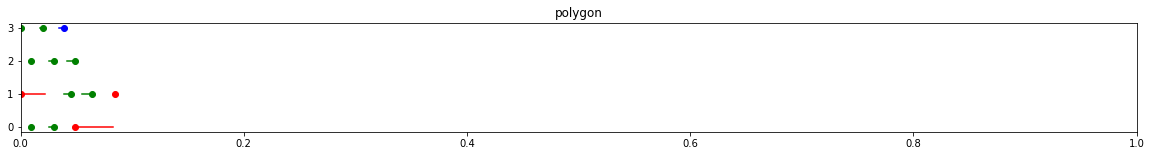

0.01573529411764707


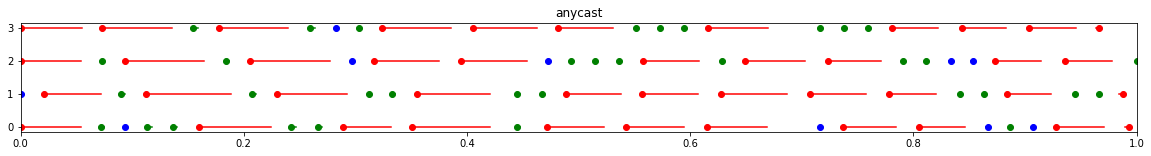

6 1733 240
0.259665320253895


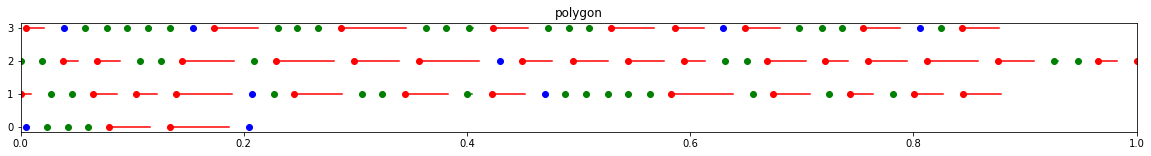

0.9018576773448989


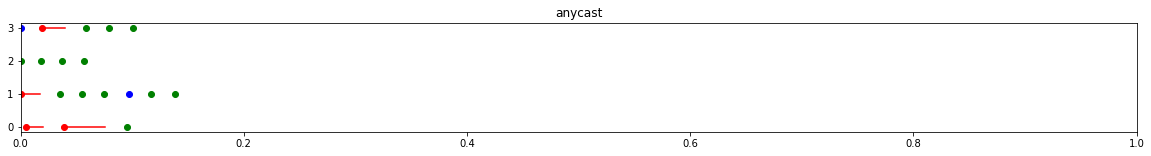

11 1720 1663
0.6886244921648288


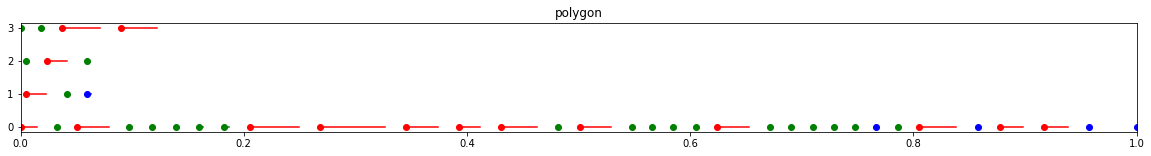

0.03848849379659505


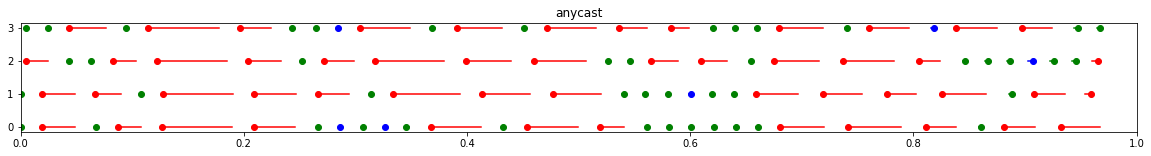

16 1687 1654
0.6616341030195383


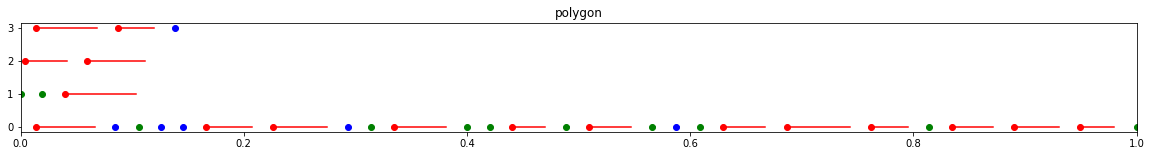

0.033014294366270736


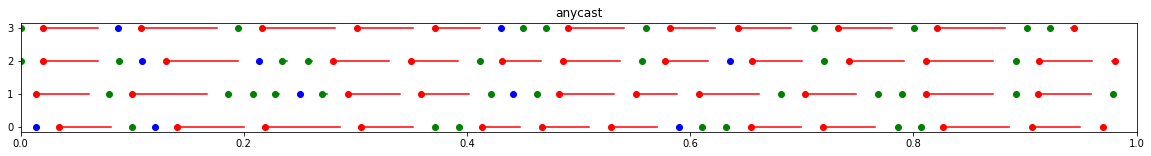

21 1155 1616
0.5795265447853075


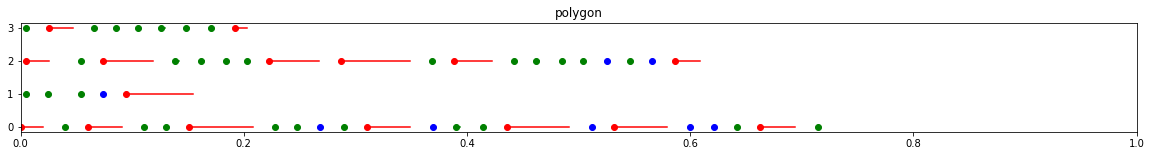

0.6349786715417428


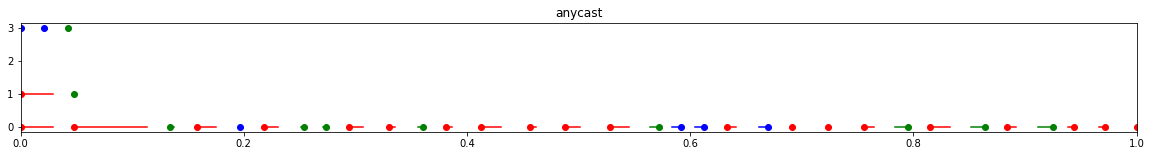

26 343 1616
0.9339503810578426


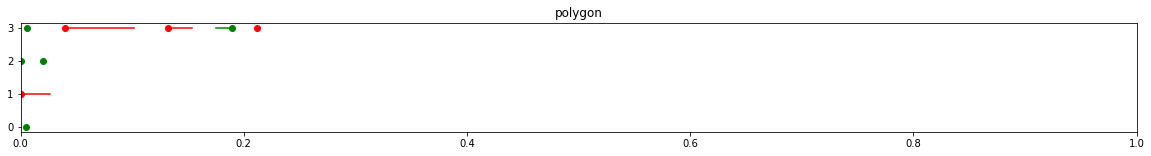

0.6641975308641975


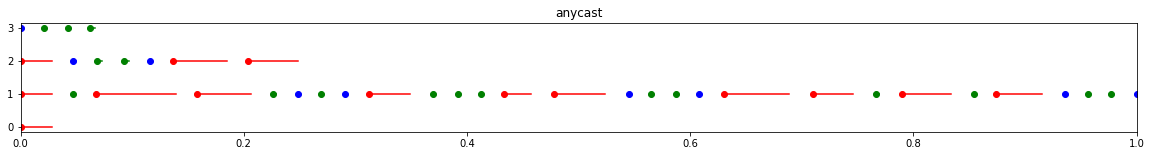

31 1647 1610
0.45066788099574984


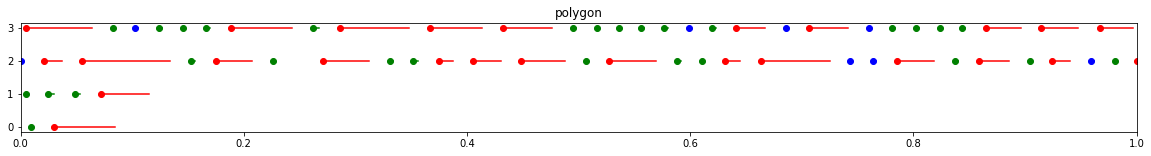

0.21382072874048927


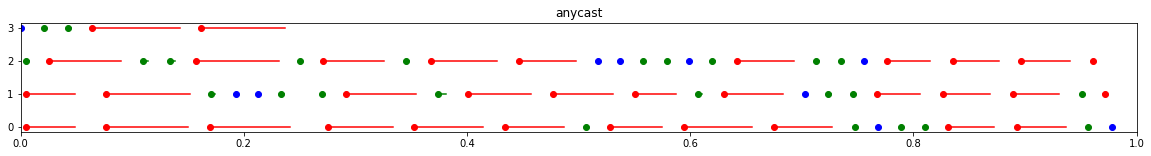

36 922 132
0.5299313052011776


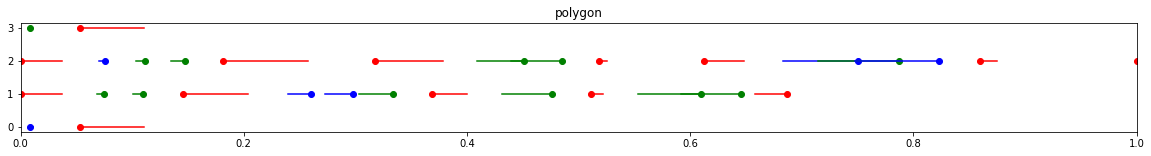

0.9485010689929618


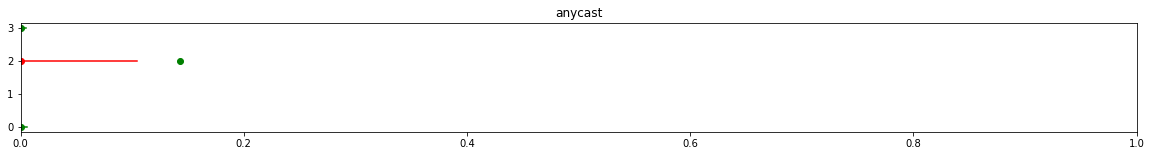

41 1605 1527
0.6427983539094649


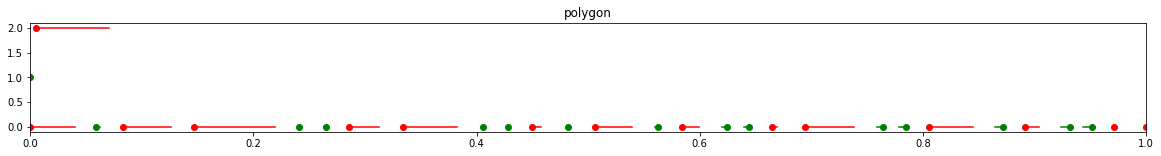

0.07302360149579529


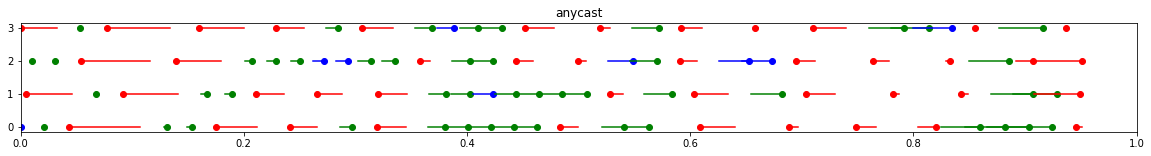

46 183 1503
0.9296299873371536


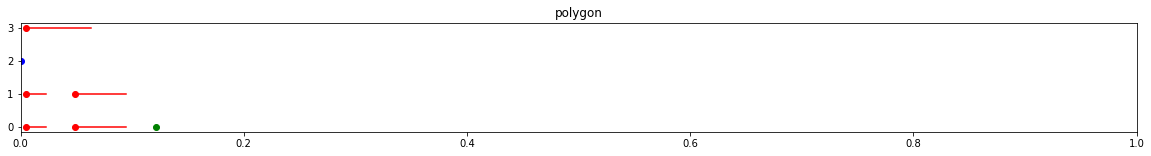

0.7051078680203046


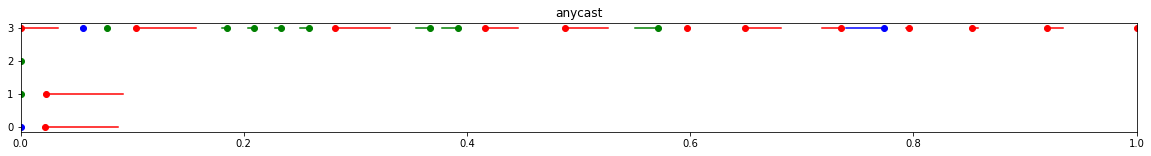

51 1592 1556
0.5546482412060302


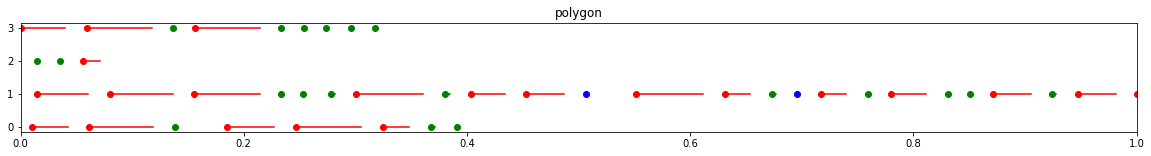

0.4870129189887861


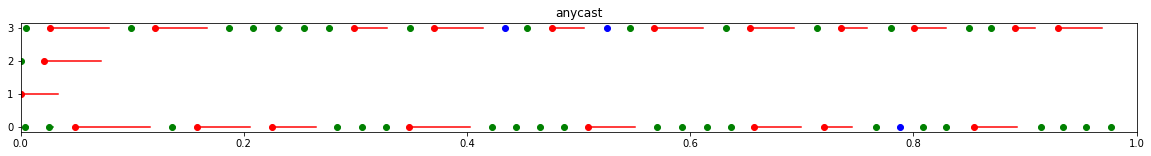

56 1365 1536
0.1126245099380015


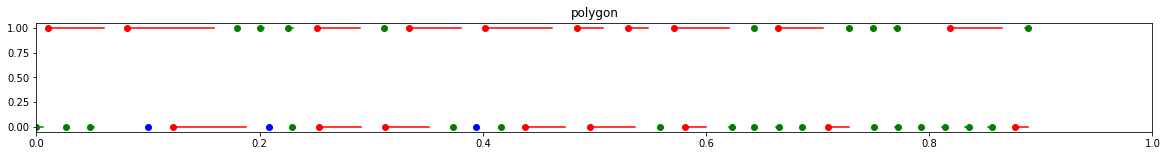

0.013924870466321265


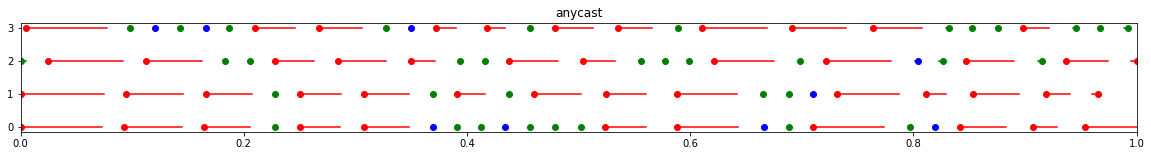

61 1495 1459
0.5667224080267559


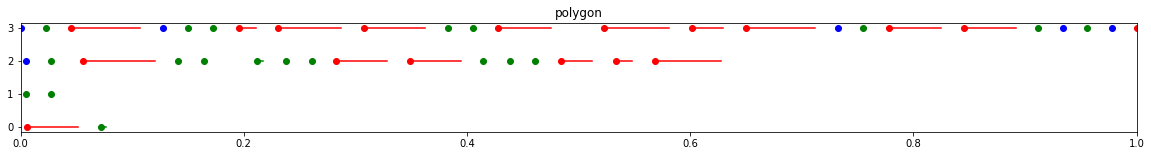

0.19296487089687742


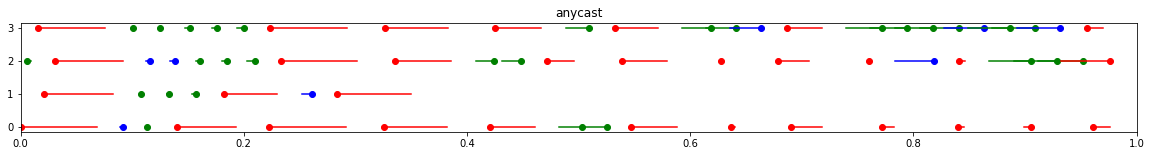

66 1521 36
0.47915298752462243


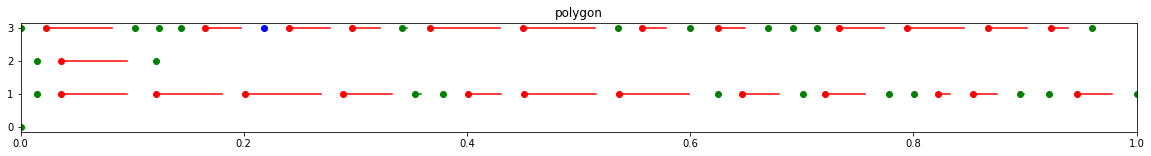

0.9779451317912856


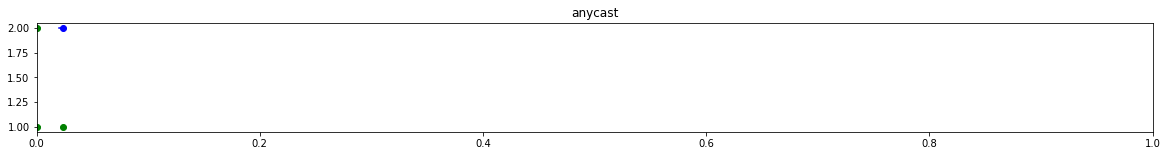

71 1261 1462
0.6463857363215167


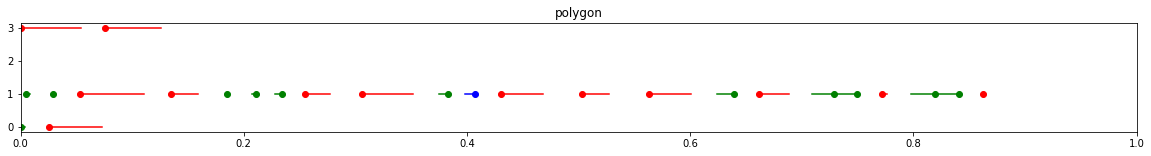

0.521701982228298


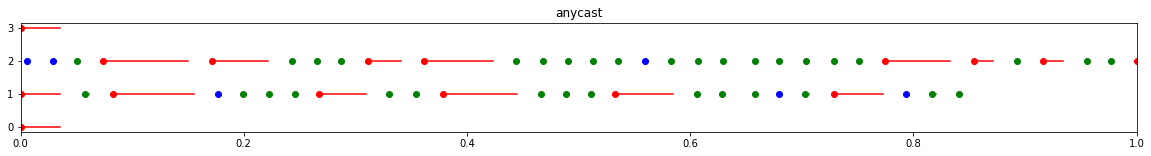

76 1514 1473
0.013348714568226755


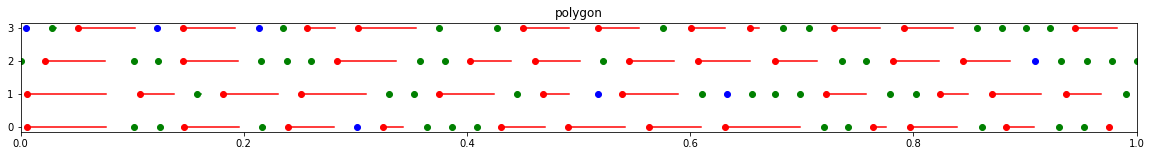

0.14365918097754296


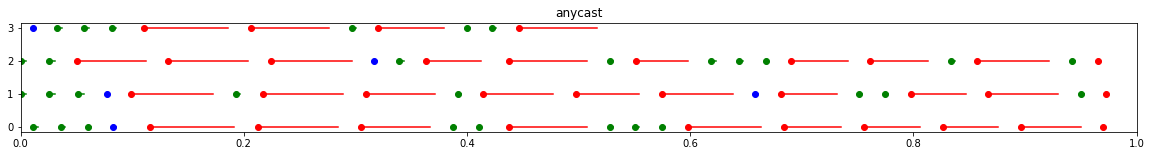

81 691 0
0.4894217207334274


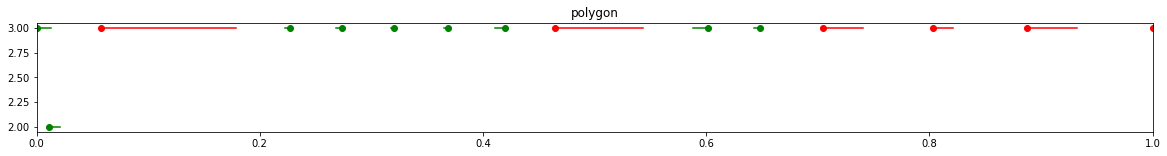

1.0


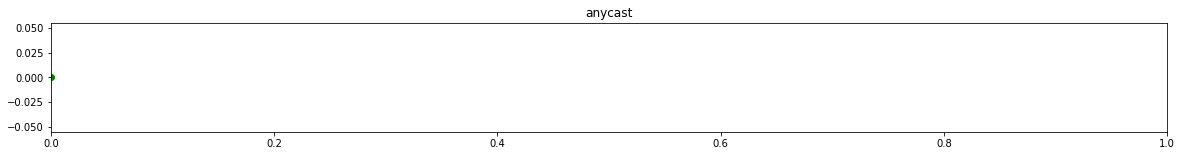

86 1490 1443
0.4993288590604027


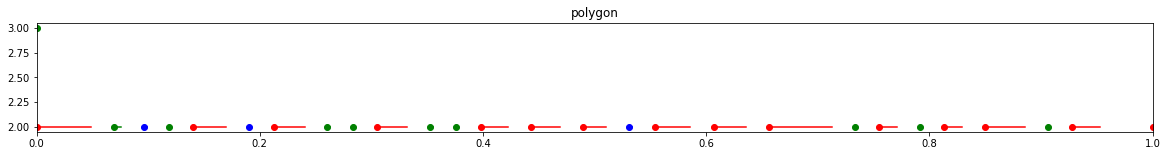

0.138255033557047


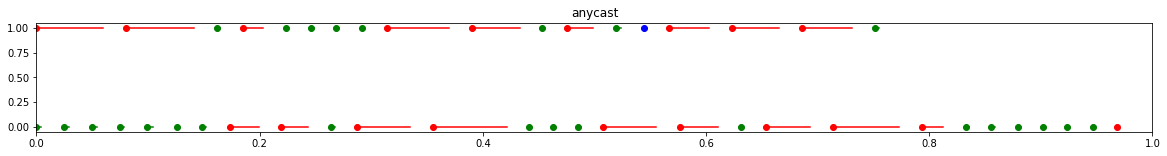

91 1465 1424
0.3265213442325159


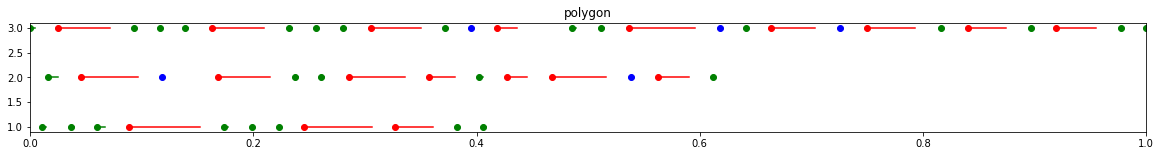

0.24425427697429636


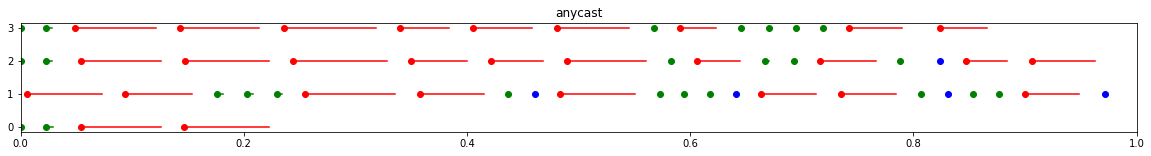

96 1194 1418
0.5484079394221146


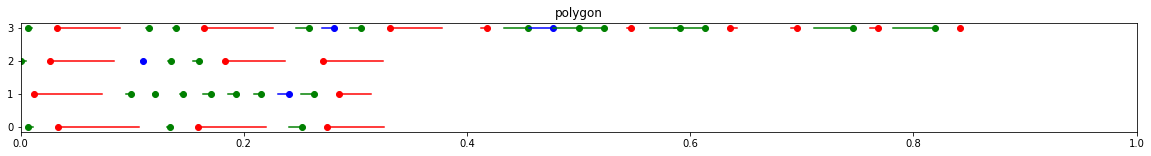

0.008802816901408439


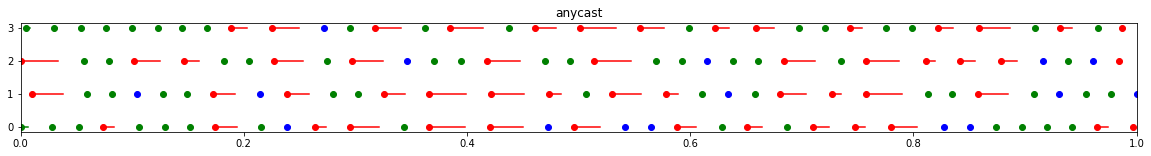

In [17]:

small_diff = []

idles = {'polygon':[],
        'anycast':[]}
last_type = {'polygon':[],
        'anycast':[]}

# for client in set(data_all_ok_type['client']):
for client in range(1,100,5):
    client = str(client)
    input_data = data_all_ok_type
    selected_data = []

    for tag in ['polygon', 'anycast']:
        tmp_tag = input_data[(input_data['tag'] == tag) & (input_data['client'] == client)]
        tmp_tag = tmp_tag.sort_values(by=['st_timestamp'])

        tmp = deepcopy(tmp_tag)
        if len(tmp) == 0:
            break
        tmp['st_offset'] = tmp['st_timestamp'] - min(tmp_tag['st_timestamp'])
        tmp['en_offset'] = tmp['en_timestamp'] - min(tmp_tag['st_timestamp'])

        if len(selected_data) == 0:
            selected_data = tmp
        else:
            selected_data = pd.concat([selected_data, tmp])


    if len(selected_data) == 0 or len(set(selected_data['tag'])) < 2:
        continue
    p_max = max(selected_data[selected_data['tag'] == 'polygon']['st_offset'])
    a_max = max(selected_data[selected_data['tag'] == 'anycast']['st_offset'])
    if p_max < a_max:
        ratio = p_max / a_max
    if p_max > a_max:
        ratio = a_max / p_max
    print(client, p_max, a_max)
    if ratio > 0.8:
        if len(small_diff) == 0:
            small_diff = selected_data
        else:
            small_diff = pd.concat([small_diff, selected_data])
    dict_y = {"polygon": 0.5,
             'anycast': 0.5}


    for tag in ['polygon', 'anycast']:
        bad_idle = {}
        bad_idle_type = {}
        fig, ax = plt.subplots(figsize=(20, 2))
        tmp_tag = selected_data[selected_data['tag'] == tag]
        port_min = min(selected_data['port'])
        st_max = max(tmp_tag['st_offset'])
        en_max = max(tmp_tag['en_offset'])

        for i, item in enumerate(tmp_tag.values):
            if item[2] == 'video':
                c = 'red'
            if item[2] == 'cpu':
                c = 'blue'
            if item[2] == 'normal_1':
                c = 'green'

            if st_max == 0:
                st_offset = 0
            else:
                st_offset = (item[-2] / st_max)
            en_offset = (item[-1] / en_max)
            if (p_max > a_max) and tag == 'anycast':
                st_offset = st_offset * ratio
                en_offset = en_offset * ratio
            if (p_max < a_max) and tag == 'polygon':
                st_offset = st_offset * ratio
                en_offset = en_offset * ratio

    #         plt.scatter(st_offset, dict_y[tag], color=c)
    #         plt.axhline(y=dict_y[tag], xmin=st_offset, xmax=en_offset, color=c)
            plt.scatter(st_offset, item[3] - port_min, color=c)
            plt.axhline(y=item[3] - port_min, xmin=st_offset, xmax=en_offset, color=c)
            bad_idle[item[3] - port_min] = en_offset
            bad_idle_type[item[3] - port_min] = item[2]

        idle = 0
        for key in bad_idle.keys():
            idle += 1 - bad_idle[key]
            last_type[tag].append(bad_idle_type[key])
        print(idle / len(bad_idle))
        idles[tag].append(idle / len(bad_idle))
        plt.xlim(0,1)
        plt.title(tag)
        plt.show()


In [18]:

small_diff = []

idles = {'polygon':[],
        'anycast':[]}
last_type = {'polygon':[],
        'anycast':[]}

for client in set(data_all_ok_type['client']):
# for client in range(1,100,5):
    client = str(client)
    input_data = data_all_ok_type
    selected_data = []

    for tag in ['polygon', 'anycast']:
        tmp_tag = input_data[(input_data['tag'] == tag) & (input_data['client'] == client)]
        tmp_tag = tmp_tag.sort_values(by=['st_timestamp'])

        tmp = deepcopy(tmp_tag)
        if len(tmp) == 0:
            break
        tmp['st_offset'] = tmp['st_timestamp'] - min(tmp_tag['st_timestamp'])
        tmp['en_offset'] = tmp['en_timestamp'] - min(tmp_tag['st_timestamp'])

        if len(selected_data) == 0:
            selected_data = tmp
        else:
            selected_data = pd.concat([selected_data, tmp])


    if len(selected_data) == 0 or len(set(selected_data['tag'])) < 2:
        continue
    p_max = max(selected_data[selected_data['tag'] == 'polygon']['st_offset'])
    a_max = max(selected_data[selected_data['tag'] == 'anycast']['st_offset'])
    if p_max < a_max:
        ratio = p_max / a_max
    if p_max > a_max:
        ratio = a_max / p_max
#     print(client, p_max, a_max)
    if ratio > 0.8:
        if len(small_diff) == 0:
            small_diff = selected_data
        else:
            small_diff = pd.concat([small_diff, selected_data])
    dict_y = {"polygon": 0.5,
             'anycast': 0.5}


    for tag in ['polygon', 'anycast']:
        bad_idle = {}
        bad_idle_type = {}
#         fig, ax = plt.subplots(figsize=(20, 2))
        tmp_tag = selected_data[selected_data['tag'] == tag]
        port_min = min(selected_data['port'])
        st_max = max(tmp_tag['st_offset'])
        en_max = max(tmp_tag['en_offset'])

        for i, item in enumerate(tmp_tag.values):
            if item[2] == 'video':
                c = 'red'
            if item[2] == 'cpu':
                c = 'blue'
            if item[2] == 'normal_1':
                c = 'green'

            if st_max == 0:
                st_offset = 0
            else:
                st_offset = (item[-2] / st_max)
            en_offset = (item[-1] / en_max)
#             if (p_max > a_max) and tag == 'anycast':
#                 st_offset = st_offset * ratio
#                 en_offset = en_offset * ratio
#             if (p_max < a_max) and tag == 'polygon':
#                 st_offset = st_offset * ratio
#                 en_offset = en_offset * ratio

    #         plt.scatter(st_offset, dict_y[tag], color=c)
    #         plt.axhline(y=dict_y[tag], xmin=st_offset, xmax=en_offset, color=c)
#             plt.scatter(st_offset, item[3] - port_min, color=c)
#             plt.axhline(y=item[3] - port_min, xmin=st_offset, xmax=en_offset, color=c)
            bad_idle[item[3] - port_min] = en_offset
            bad_idle_type[item[3] - port_min] = item[2]
    #         plt.text(0.5, dict_y[tag] + 0.02,tag)

    #     plt.ylim(0.4,0.6)
        idle = 0
        for key in bad_idle.keys():
            idle += 1 - bad_idle[key]
            last_type[tag].append(bad_idle_type[key])
#         print(idle / len(bad_idle))
        idles[tag].append(idle / len(bad_idle))
#         plt.xlim(0,1)
#         plt.title(tag)
#         plt.show()


In [19]:
np.mean(idles['polygon']), np.mean(idles['anycast'])

(0.4146283393583649, 0.2858431663541178)

In [20]:
np.median(idles['polygon']), np.median(idles['anycast'])

(0.4486020626081315, 0.26377705105523686)

In [21]:
tmp = []
for key in idles.keys():
    for item in idles[key]:
        tmp.append([key, item])
tmp = pd.DataFrame(tmp, columns=['tag', 'v'])

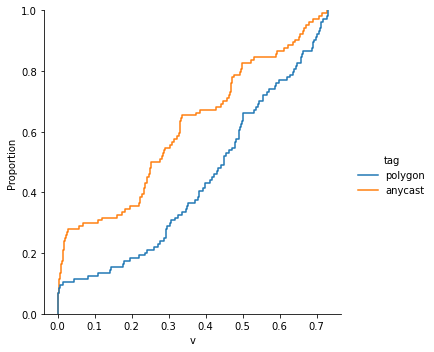

In [22]:
sns.displot(data=tmp, x='v', hue='tag', kind="ecdf")


In [23]:
Counter(last_type['polygon']), Counter(last_type['anycast'])

(Counter({'normal_1': 160, 'video': 180, 'cpu': 24}),
 Counter({'video': 196, 'normal_1': 140, 'cpu': 24}))

In [24]:
data_all_ok_type['excution_time'] = data_all_ok_type['en_timestamp'] - data_all_ok_type['st_timestamp']

In [25]:
data_all_ok_type

,tag,client,request_type,port,st_timestamp,en_timestamp,excution_time
0,anycast,100,video,14837,1653917880,1653917956,76
1,anycast,100,normal_1,14835,1653917988,1653917993,5
2,anycast,100,normal_1,14837,1653918668,1653918672,4
3,anycast,100,normal_1,14837,1653918389,1653918392,3
4,anycast,100,normal_1,14835,1653917919,1653917923,4
...,...,...,...,...,...,...,...
10339,polygon,13,video,14489,1653924298,1653924402,104
10340,polygon,13,normal_1,14488,1653924234,1653924235,1
10341,polygon,64,cpu,14691,1653924364,1653924367,3
10342,polygon,64,normal_1,14692,1653924395,1653924403,8


<AxesSubplot:xlabel='request_type', ylabel='excution_time'>

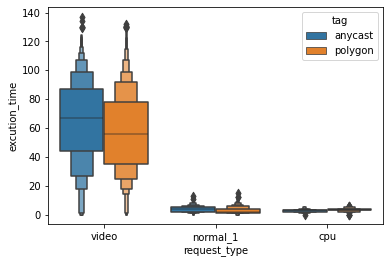

In [26]:
sns.boxenplot(data=data_all_ok_type, x='request_type', y ='excution_time', hue='tag')